## Imports

In [212]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Set up

In [213]:
metal = 'nickel'

## Read from import/export

In [214]:
# Load the datasets
import_data = pd.read_csv(f'metals/{metal}/{metal}_import.csv')
export_data = pd.read_csv(f'metals/{metal}/{metal}_export.csv')
global_data = pd.read_csv(f'metals/{metal}/{metal}_global.csv')

# Filter data for the years 2011 to 2021
import_data = import_data[import_data['Year'].between(2000, 2021)]
export_data = export_data[export_data['Year'].between(2000, 2021)]
global_data = global_data[global_data['Year'].between(2000, 2021)]

# Distinguishing import / export
import_data['Trade Type'] = 'Import'
export_data['Trade Type'] = 'Export'

# Combine datasets 
combined_trade = pd.concat([import_data, export_data], ignore_index=True)

if metal == 'nickel':
    combined_trade.rename(columns={'Political Stability and Absence of Violence/Terrorism: Estimate': 'Political Stability'}, inplace=True)

# combined_trade.dropna(inplace=True)

# Merge with global data
global_data.rename(columns={'Price per Metric Ton': f'Global {metal} Price'}, inplace=True)
combined_data = pd.merge(combined_trade, global_data, on='Year')
# combined_data.dropna(inplace=True)

combined_data.head(100)
# len(combined_data)

,Country,Country ID,Year,Product Trade Value,Product Growth,Product Growth Rate,Gross Trade Value,Product Percentage,Political Stability,Trade Type,Global nickel Price
0,South Africa,afzaf,2000,120730891,6951842500,1.357451,29370671067,0.411059,NaN,Import,8630.517694
1,China,aschn,2000,180437374,9218522300,1.044566,172144503941,0.104817,NaN,Import,8630.517694
2,Japan,asjpn,2000,1294868719,48596407600,0.600768,358340295002,0.361352,NaN,Import,8630.517694
3,South Korea,askor,2000,606675671,15750620400,0.350661,157216538181,0.385885,NaN,Import,8630.517694
4,Austria,euaut,2000,113143879,4623565900,0.691031,68115020387,0.166107,NaN,Import,8630.517694
...,...,...,...,...,...,...,...,...,...,...,...
95,Canada,nacan,2004,3760488088,164931174800,0.781229,306469281046,1.227036,NaN,Export,13821.009270
96,Cuba,nacub,2004,1106015986,46614926600,0.728510,2690294150,41.111340,NaN,Export,13821.009270
97,Australia,ocaus,2004,2424023372,72970523500,0.430678,90580430380,2.676101,NaN,Export,13821.009270
98,New Caledonia,ocncl,2004,138285286,4588357300,0.496566,1099369174,12.578603,NaN,Export,13821.009270


## Processing data

In [215]:
# Scaling the features
scaler = StandardScaler()
if metal == 'nickel':
    numerical_cols = ['Product Trade Value', 'Product Growth', 'Product Growth Rate', 'Gross Trade Value', 'Product Percentage', 'Political Stability', f'Global {metal} Price']
else:
    numerical_cols = ['Product Trade Value', 'Product Growth', 'Product Growth Rate', 'Gross Trade Value', 'Product Percentage', f'Global {metal} Price']

combined_data[numerical_cols] = scaler.fit_transform(combined_data[numerical_cols])

# Preparing features and target variable
# X = combined_data.drop(['Global Nickel Price', 'Country', 'Country ID', 'Year', 'Trade Type'], axis=1)
if metal == 'nickel':
    X = combined_data.drop([f'Global {metal} Price', 'Country', 'Country ID', 'Year', 'Trade Type', 'Political Stability'], axis=1)
else:
    X = combined_data.drop([f'Global {metal} Price', 'Country', 'Country ID', 'Year', 'Trade Type'], axis=1)
y = combined_data[f'Global {metal} Price']

## Build / Train NN

In [216]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Regression output

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=None)
    

## Visualize

3/3 [==============================] - 0s 2ms/step - loss: 0.8478 - mean_absolute_error: 0.7279
Test Loss: 0.8478265404701233
Mean Absolute Error: 0.7279460430145264


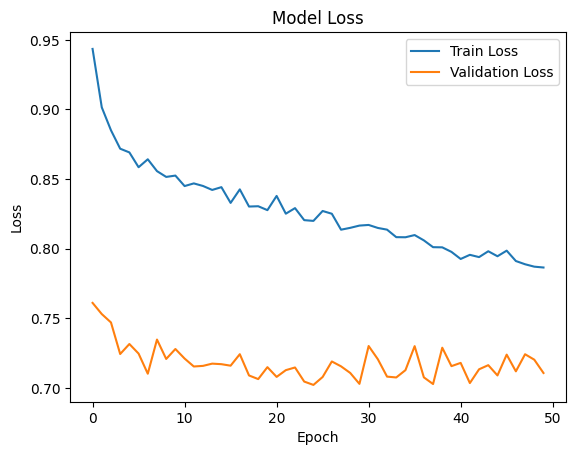

In [217]:
import matplotlib.pyplot as plt

test_loss, mean_absolute_error = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Mean Absolute Error: {mean_absolute_error}')

# Plotting training loss vs. validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()